In [201]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class Corner_Singularity_2D(Dataset):
    def __init__(self, nb_points_in_omega=1000, nb_points_on_boundary=500, lower_bound_xy=[-1, -1], uper_bound_xy=[1, 1]):

        self.lower_bound_xy = lower_bound_xy
        self.upper_bound_xy = uper_bound_xy

        self.nb_points_in_omega = nb_points_in_omega
        self.nb_points_on_boundary = nb_points_on_boundary
        self.omega_coordinates, self.boundary_coordinates = self._create_points_in_domain(self.nb_points_in_omega, self.nb_points_on_boundary, self.lower_bound_xy, self.upper_bound_xy)

        self.omega_uniform_coordinates, self.boundary_uniform_coordinates, self.uniform_all_points = self._create_points_in_omega_uniform([9, 9], self.lower_bound_xy, self.upper_bound_xy)

    def __getitem__(self, index):
        return self.omega_coordinates[index]
    
    def __len__(self):
        return self.nb_points_in_omega + self.nb_points_on_boundary

    def  _create_points_in_domain(self, nb_points_in_omega, nb_points_on_boundary, lower_bound_xy, upper_bound_xy, tol_boundary=1e-6):
        xmin, ymin = lower_bound_xy
        xmax, ymax = upper_bound_xy
        x_points_in_omega = np.random.uniform(xmin+tol_boundary, xmax-tol_boundary, nb_points_in_omega)
        y_points_in_omega = np.random.uniform(ymin+tol_boundary, ymax-tol_boundary, nb_points_in_omega)
        omega_coordinates = np.vstack((x_points_in_omega, y_points_in_omega)).T

        corner_singularity_mask = ~((omega_coordinates[:, 1] <= tol_boundary) & (omega_coordinates[:, 1] >= -tol_boundary) & (xmin+tol_boundary <= omega_coordinates[:, 0]) & (omega_coordinates[:, 0] <= 0))
        omega_coordinates = omega_coordinates[corner_singularity_mask]

        nb_points_per_boundary = nb_points_on_boundary // 5
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.random.uniform(ymin, ymin+tol_boundary, nb_points_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.random.uniform(ymax-tol_boundary, ymax, nb_points_per_boundary)
        x_right, y_right = np.random.uniform(xmax-tol_boundary, xmax, nb_points_per_boundary), np.random.uniform(ymin, ymax, nb_points_per_boundary)
        x_left, y_left = np.random.uniform(xmin, xmin+tol_boundary, nb_points_per_boundary), np.random.uniform(ymin, ymax, nb_points_per_boundary)
        x_corner, y_corner = np.random.uniform(xmin+tol_boundary, 0, nb_points_per_boundary), np.random.uniform(-tol_boundary, tol_boundary, nb_points_per_boundary)

        x_boundary = np.concatenate((x_bottom, x_top, x_right, x_left, x_corner))
        y_boundary = np.concatenate((y_bottom, y_top, y_right, y_left, y_corner))

        boundary_coordinates = np.vstack((x_boundary, y_boundary)).T

        self.nb_points_on_boundary = len(boundary_coordinates)
        self.nb_points_in_omega = len(omega_coordinates)

        return omega_coordinates, boundary_coordinates

    def _create_points_in_omega_uniform(self, grid_size, lower_bound_xy, upper_bound_xy):
        mesh = RectangleMesh(Point(lower_bound_xy[0], lower_bound_xy[1]), Point(upper_bound_xy[0], upper_bound_xy[1]), grid_size[0], grid_size[1])
        mesh_coordinates = mesh.coordinates()

        boundary_mask = [(x, y) for x, y in mesh_coordinates if ((x == -1) or (x == 1) or (y == -1) or (y == 1))]
        extra_points_for_boundary = [(x, 0) for x in np.linspace(-1+1e-6, 0, 40)]
        boundary_mask.extend(extra_points_for_boundary)
        omega_mask = [(x, y) for x, y in mesh_coordinates if not ((y == 0 and -1 <= x <= 0) or (x == -1) or (x == 1) or (y == -1) or (y == 1))]

        boundary_coordinates = np.array(boundary_mask)
        boundary_coordinates = boundary_coordinates[np.lexsort((boundary_coordinates[:, 0], boundary_coordinates[:, 1]))]
        omega_coordinates = np.array(omega_mask)

        return omega_coordinates, boundary_coordinates, mesh_coordinates

    def plot_domain(self, label=True):
        plt.scatter(self.omega_coordinates[:, 0], self.omega_coordinates[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_coordinates[:, 0], self.boundary_coordinates[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        if label:
            plt.legend()
        plt.show()   

In [211]:
# DEVICE CHECK #

if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


In [202]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [203]:
import sys
import os
import importlib
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'ModelsNN'))
import recurrent_nn as rnn
importlib.reload(rnn)

model = rnn.RitzModel(2)
total_params = model.nb_params
print(f"Le modèle possède : {total_params} paramètres")

Le modèle possède : 921 paramètres


In [204]:
def u_true(x):
    x, y = x[:, 0], x[:, 1]
    r, theta = cart2pol(x, y)
    return r**(1/2) * np.sin(theta/2)

def f_true(x):
    return np.zeros(x.shape[0])

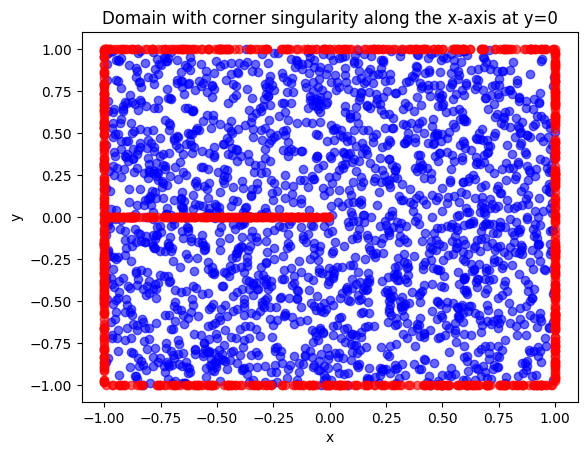

In [214]:
# Always check that we have the corner singularity in the domain
omega = Corner_Singularity_2D(2000, 1000)
omega.plot_domain(False)
ix_omega = omega.omega_coordinates
ix_boundary = omega.boundary_coordinates
true_boundary = torch.FloatTensor(u_true(ix_boundary)).reshape(len(ix_boundary),1) 

In [216]:
batch_size_train = 128
train_loader = DataLoader(omega.omega_coordinates, batch_size=batch_size_train, shuffle=True)

In [207]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [208]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self):
        super(DeepRitzLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.
    
    def forward(self, x_in_omega, output_ux_in_omega, true_operator_x, output_on_boundary, true_value_on_boundary, boundary_regulizer=500):
        grad_u = grad(flat(output_ux_in_omega), x_in_omega, create_graph=True, allow_unused=True)[0]

        physical_term1 = torch.abs(grad_u)**2
        physical_term2 = -true_operator_x*output_ux_in_omega
        boundary_loss = self.mse(output_on_boundary, true_value_on_boundary)

        total_loss = torch.mean(0.5*physical_term1) + torch.mean(physical_term2) + boundary_regulizer*boundary_loss
        self.loss = total_loss.item()
        return total_loss

In [220]:
from tqdm import tqdm 

integration_grid = Corner_Singularity_2D(1000, 100)
mc_integration_points_in_omega = torch.FloatTensor(integration_grid.omega_coordinates)
mc_integration_points_on_boundary = torch.FloatTensor(integration_grid.boundary_coordinates)
mc_true_boundary = torch.FloatTensor(u_true(mc_integration_points_on_boundary)).reshape(integration_grid.nb_points_on_boundary, 1)

mc_integration_points_in_omega.requires_grad = True
mc_integration_points_on_boundary.requires_grad = True

ritz_model = rnn.RitzModel(2)
criterion = DeepRitzLoss()
model_optimizer = torch.optim.Adam(ritz_model.parameters(), lr=0.0005)
epochs = 1000

train_loss_per_epoch = []

for epoch_i in range(epochs):
    ritz_model.train()
    train_loss_epoch_i = 0

    integration_grid = Corner_Singularity_2D()
    mc_integration_points_in_omega = torch.FloatTensor(integration_grid.omega_coordinates)
    mc_integration_points_on_boundary = torch.FloatTensor(integration_grid.boundary_coordinates)
    mc_true_boundary = torch.FloatTensor(u_true(mc_integration_points_on_boundary)).reshape(integration_grid.nb_points_on_boundary, 1)

    mc_integration_points_in_omega.requires_grad = True
    mc_integration_points_on_boundary.requires_grad = True

    for x_batch in tqdm(train_loader, desc=f'Epoch {epoch_i+1}', colour='blue'):

        fmc_integration_points = torch.FloatTensor(f_true(mc_integration_points_in_omega)).reshape(integration_grid.nb_points_in_omega, 1)
        fmc_integration_points.requires_grad = True

        model_optimizer.zero_grad()

        mc_output_omega = ritz_model(mc_integration_points_in_omega)
        mc_output_boundary = ritz_model(mc_integration_points_on_boundary)
        
        total_loss = criterion(x_in_omega=mc_integration_points_in_omega, output_ux_in_omega=mc_output_omega, true_operator_x=fmc_integration_points, output_on_boundary=mc_output_boundary, true_value_on_boundary=mc_true_boundary, boundary_regulizer=500)
        train_loss_epoch_i += total_loss.item()
        
        total_loss.backward()
        model_optimizer.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))

Epoch 1000: 100%|██████████| 16/16 [00:00<00:00, 66.52it/s]


1500
Diff mean : 0.06800894439220428


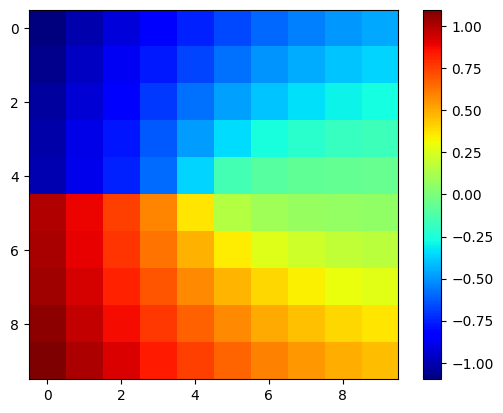

In [221]:
omega_final = Corner_Singularity_2D()
print(len(omega_final))

x = torch.FloatTensor(omega_final.uniform_all_points)

ritz_model.eval()
model_output = (ritz_model(x).detach().numpy()).reshape(10, 10)
true_u = (u_true(x).detach().numpy()).reshape(10, 10)

diff_abs = np.abs(true_u - model_output)
diff_mean = np.mean(diff_abs)

plt.imshow(true_u, cmap='jet')
plt.colorbar()

print(f'Diff mean : {diff_mean}')

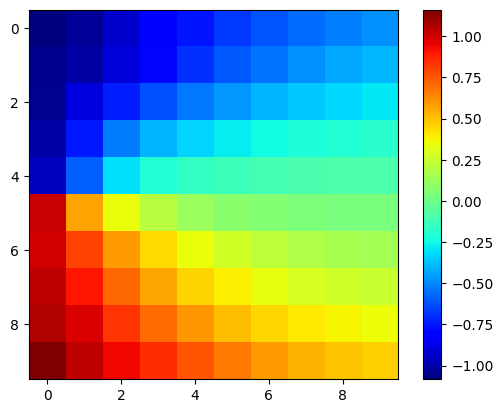

In [222]:
plt.imshow(model_output, cmap='jet')
plt.colorbar()

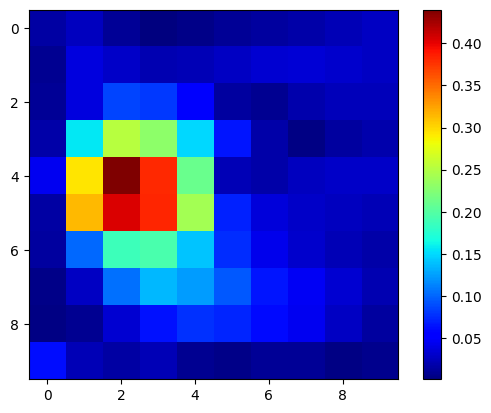

In [223]:
plt.imshow(diff_abs, cmap='jet')
plt.colorbar()

In [200]:
points = np.random.uniform(-1, 1, (10000, 2))
mask = ~((points[:, 1] <= 1e-3) & (points[:, 1] >= -1e-3) & (-1 <= points[:, 0]) & (points[:, 0] <= 0))
filtered_points = points[mask]
print(len(filtered_points))

9993
